# 多层感知机
本篇开始介绍多层感知机，首先回忆一下之前介绍的线性回归和softmax回归模型（逻辑回归只是特殊的softmax回归）：
+ 线性回归：输入经过一个线性变换直接得到输出
+ softmax回归：输入经过一个线性变换，再经过一个sigmod函数得到输出

我们进一步思考，假设输入到输出之间不止有一次线性变换会怎么样？我们以逻辑回归为例：
+ softmax回归：输入经过一个线性变换得到一个向量，再经过一个线性变换得到一个向量，......，再经过一个sigmod函数得到输出

其实如果只是这样简单的增加多层线性变换，通过数学推导可以得知相当于一层线性变换，只是对应的参数变多而已。所以我们的关键是在与线性变换之后需要增加一点非线性变换，那么就需要一种变换将输出变一下，这种变换就是激活函数，这样就变成了：    
+ softmax回归：输入经过一个线性变换+激活函数得到一个向量，再经过一个线性变换+激活函数得到一个向量，......，再经过一个sigmod函数得到输出

总结来说，前面介绍的线性回归和softmax回归模型都是经典的机器学习模型，它们从输入到输出中间只有一层变换。从本篇开始正式进入深度学习的领域，开始介绍多层感知机，深度体现在输入到输出直接会有多层变换。多层感知机特殊之处在于中间的变换都是全连接变换。
经过上面分析，下面给出多层感知机的模型构成：

## 1. 模型构成
+ 数据：和线性回归、softmax回归模型一样
+ 模型：最后一层和线性回归、softmax回归模型是一样的，只不过首层会经过多次全连接层+激活函数得到中间层，一直到倒数第一层
+ 参数：和线性回归、softmax回归模型一样
+ 损失函数：和线性回归、softmax回归模型一样
+ 优化方法：梯度下降等，得益于 PyTorch 自动求梯度，我们不再需要显示求出损失函数的导数

下面重点认识一下激活函数。

## 2. 激活函数
常用的激活函数主要有：sigmoid、relu、tanh，下面我们用代码分别绘制它们的曲线和函数导数曲线。

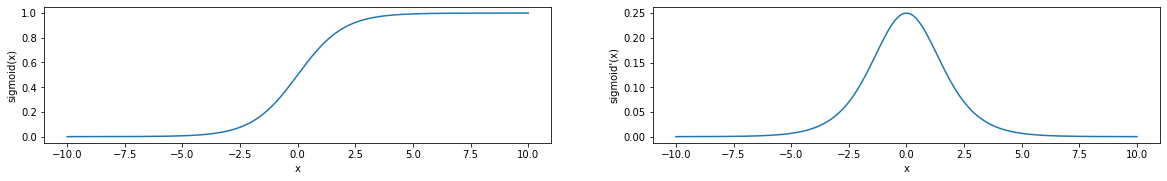

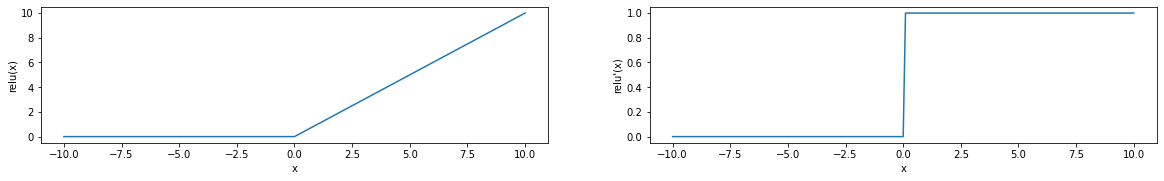

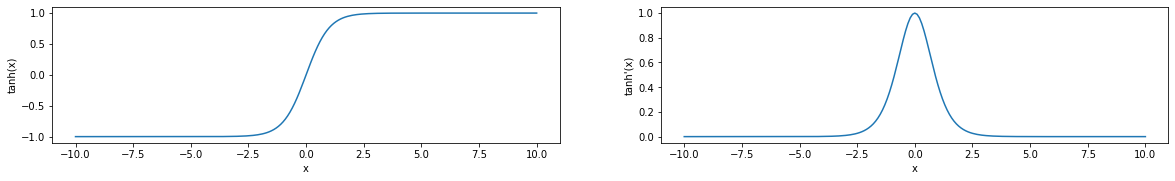

In [17]:
import matplotlib.pyplot as plt
import torch

def plot_x_y(x, y, name):
    _, figs = plt.subplots(1, 2, figsize=(20, 2.5))
    figs[0].plot(x.detach().numpy(), y.detach().numpy())
    figs[0].set_xlabel('x')
    figs[0].set_ylabel(name + '(x)')
    y.sum().backward()
    figs[1].plot(x.detach().numpy(), x.grad.detach().numpy())
    figs[1].set_xlabel('x')
    figs[1].set_ylabel(name + '\'(x)')
    plt.show()

x = torch.range(-10, 10, 0.1, requires_grad=True)
y = torch.sigmoid(x)
plot_x_y(x, y, 'sigmoid')
x.grad.zero_()
y = torch.relu(x)
plot_x_y(x, y, 'relu')
x.grad.zero_()
y = torch.tanh(x)
plot_x_y(x, y, 'tanh')

## 3. 多层感知机实现
设置隐含层的数量为 256

In [26]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pytorch_lightning as pl
import numpy as np

class MultiLayerModel(pl.LightningModule):

    def __init__(self):
        super(MultiLayerModel, self).__init__()
        # 定义模型结构
        self.l1 = torch.nn.Linear(28*28, 256)
        self.l2 = torch.nn.Linear(256, 10)

    def forward(self, x):
        # 必须：定义模型
        x = self.l1(x.view(x.size(0), -1))
        x = torch.relu(x)
        return torch.log_softmax(self.l2(x), dim=1)

    def training_step(self, batch, batch_nb):
        # 必须提供：定于训练过程
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # 可选提供：定义测试过程
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.nll_loss(y_hat, y)}

    def test_epoch_end(self, outputs):
        # 可选提供：定义测试过程
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # 必须提供：定义优化器
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.SGD(self.parameters(), lr=0.01)

    def train_dataloader(self):
        # 必须提供：提供训练数据集
        mnist_train = torchvision.datasets.FashionMNIST('../../datas', train=True, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))
        return DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4)

    def test_dataloader(self):
        # 可选提供：提供测试数据集
        mnist_test = torchvision.datasets.FashionMNIST('../../datas', train=False, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))
        return DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=1)

In [27]:
ml_model = MultiLayerModel()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(max_epochs=20)
trainer.fit(ml_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 200 K 
1 | l2   | Linear | 2 K   
Epoch 20: 100%|██████████| 469/469 [00:04<00:00, 113.60it/s, loss=0.352, v_num=42]


1

In [28]:
res = trainer.test()

Testing:  96%|█████████▌| 76/79 [00:01<00:00, 53.53it/s]--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.3744)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 79/79 [00:01<00:00, 53.06it/s]


## 4. 查看预测结果

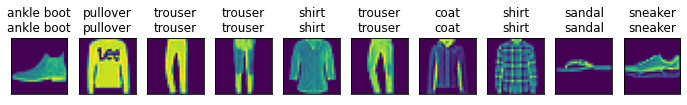

In [32]:
import matplotlib.pyplot as plt
# 获取每一个图片对应类别的英文解释
mnist_test = torchvision.datasets.FashionMNIST('../../datas', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
def get_fashion_mnist_label_name(label_id):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return text_labels[label_id]

def show_fasion_mnist_head(head_num, mnist):
    _, figs = plt.subplots(1, head_num, figsize=(12, 12))
    for i in range(0, head_num):
        imgs, t_label_id = mnist[i]
        p_label_id = torch.argmax(ml_model(imgs))
        f = figs[i]
        f.imshow(imgs.view(28, 28))
        f.set_title(get_fashion_mnist_label_name(t_label_id) + '\n' + get_fashion_mnist_label_name(p_label_id))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

show_fasion_mnist_head(10, mnist_test)

## 5. 查看准确率和混淆矩阵

In [33]:
import matplotlib.pyplot as plt
from pytorch_lightning.metrics.functional import confusion_matrix
from pytorch_lightning.metrics.functional import accuracy
imgs, target = iter(ml_model.test_dataloader()).next()
p_labels_logic = ml_model(imgs)
p_labels = torch.argmax(p_labels_logic, dim=1)
accuracy = accuracy(p_labels, target)
cm = confusion_matrix(p_labels, target)

accuracy= tensor(0.8750)
confusion_matrix=
 tensor([[12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0., 15.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  9.,  1.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  0.,  1.,  0.,  7.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  7.]])


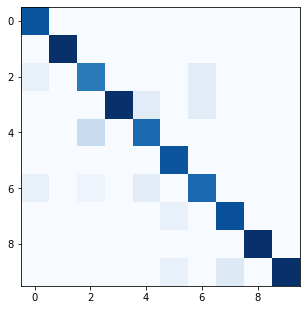

In [34]:
print('accuracy=', accuracy)
print('confusion_matrix=\n', cm)
cm_numpy = cm.numpy()
class_nums = cm_numpy.sum(axis=0)
plt.figure(figsize=(5, 20))
plt.imshow(cm_numpy/class_nums, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.show()

增加一个隐藏层的多层感知机准确率（0.8750）相比softmax回归准确率（0.8594）有绝对1.56%的效果提升，而且是在其他参数没有任何改变的情况下。